In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

# Display settings
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')

# ========================
# 2. Load the Data
# ========================

train = pd.read_csv("C:\\Users\\user\\OneDrive\\Desktop\\DS\\Project\\Train.csv")
test = pd.read_csv("C:\\Users\\user\\OneDrive\\Desktop\\DS\\Project\\Test.csv")

print("Train Shape:", train.shape)
train.head()

# ========================
# 3. Initial Data Cleaning
# ========================
drop_cols = [
    'Amount', 'batch ID', 'Currency', 'Country code', 'Provider ID',
    'Channel ID', 'Loan issued date', 'currency', 'Amount loan',
    'loan ID', 'loan application ID', 'Payback ID', 'ThirdPartyID',
    'IsThirdPartyConfirmed'
]

train.drop(columns=drop_cols, inplace=True, errors='ignore')
train.dropna(inplace=True)
train.reset_index(drop=True, inplace=True)


Train Shape: (2100, 27)


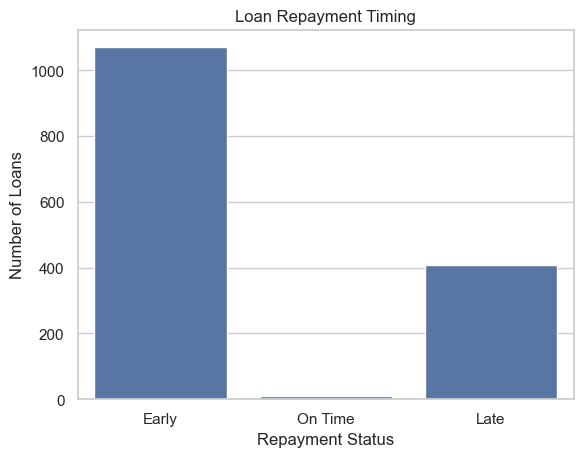

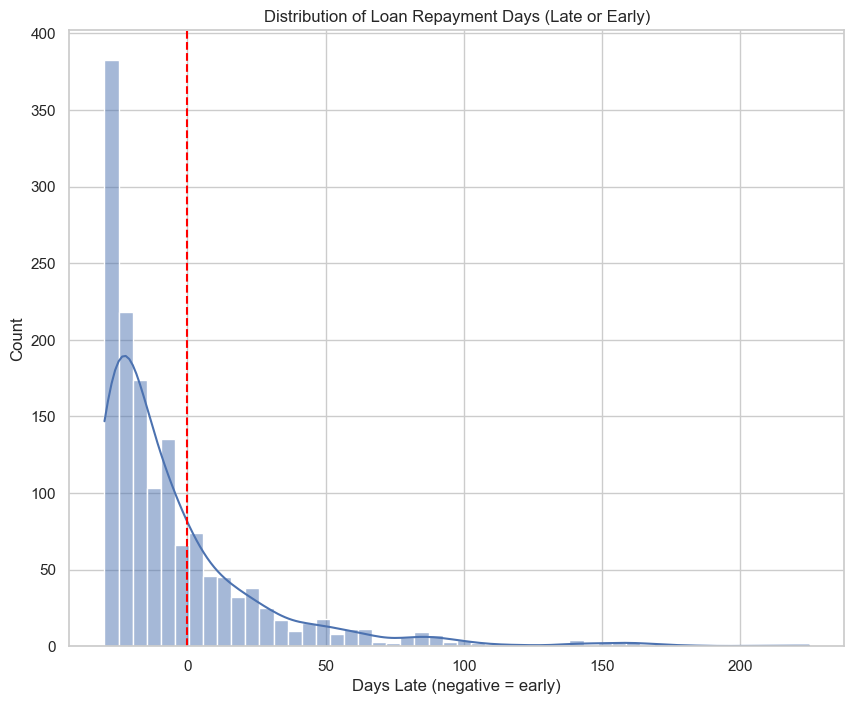

In [3]:
# ========================
# EDA: Loan Repayment vs Due Date
# ========================

# Load original data again if columns were dropped
full_train = pd.read_csv("C:\\Users\\user\\OneDrive\\Desktop\\DS\\Project\\Train.csv")

# Ensure both date columns exist
if 'PaidOnDate' in full_train.columns and 'DueDate' in full_train.columns:
    
    # Convert to datetime
    full_train['PaidOnDate'] = pd.to_datetime(full_train['PaidOnDate'], errors='coerce')
    full_train['DueDate'] = pd.to_datetime(full_train['DueDate'], errors='coerce')
    
    # Drop rows with invalid or missing dates
    full_train.dropna(subset=['PaidOnDate', 'DueDate'], inplace=True)

    # Calculate days early/late
    full_train['Days_Late'] = (full_train['PaidOnDate'] - full_train['DueDate']).dt.days

    # Add repayment status
    full_train['Repayment_Status'] = full_train['Days_Late'].apply(
        lambda x: 'On Time' if x == 0 else ('Late' if x > 0 else 'Early')
    )

    # Distribution of repayment status
    sns.countplot(x='Repayment_Status', data=full_train, order=['Early', 'On Time', 'Late'])
    plt.title('Loan Repayment Timing')
    plt.xlabel('Repayment Status')
    plt.ylabel('Number of Loans')
    plt.show()

    # Histogram of days late or early
    plt.figure(figsize=(10, 8))
    sns.histplot(full_train['Days_Late'], bins=50, kde=True)
    plt.axvline(0, color='red', linestyle='--')
    plt.title('Distribution of Loan Repayment Days (Late or Early)')
    plt.xlabel('Days Late (negative = early)')
    plt.ylabel('Count')
    plt.show()

    # Boxplot of lateness by Good_Bad_flag if available
    if 'Good_Bad_flag' in full_train.columns:
        plt.figure(figsize=(10, 8))
        sns.boxplot(x='Good_Bad_flag', y='Days_Late', data=full_train)
        plt.title('Days Late vs Good_Bad_flag')
        plt.show()
else:
    print("Required columns 'PaidOnDate' or 'DueDate' not found in the dataset.")


C:\Users\user\AppData\Local\Temp\ipykernel_13004\1661053828.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='IsDefaulted', data=train, palette=['mediumseagreen', 'salmon'])


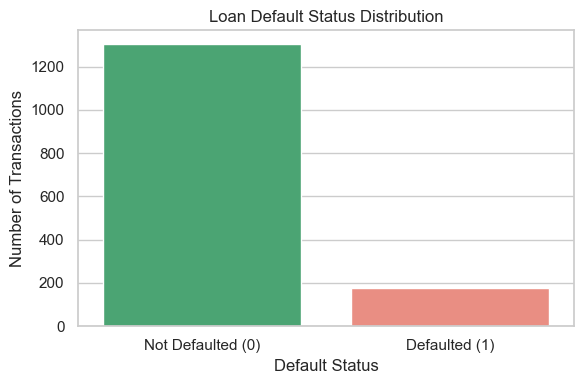

In [4]:
# Bar chart
plt.figure(figsize=(6, 4))
sns.countplot(x='IsDefaulted', data=train, palette=['mediumseagreen', 'salmon'])

# Labeling
plt.xticks([0, 1], ['Not Defaulted (0)', 'Defaulted (1)'])
plt.title('Loan Default Status Distribution')
plt.xlabel('Default Status')
plt.ylabel('Number of Transactions')
plt.tight_layout()
plt.show()

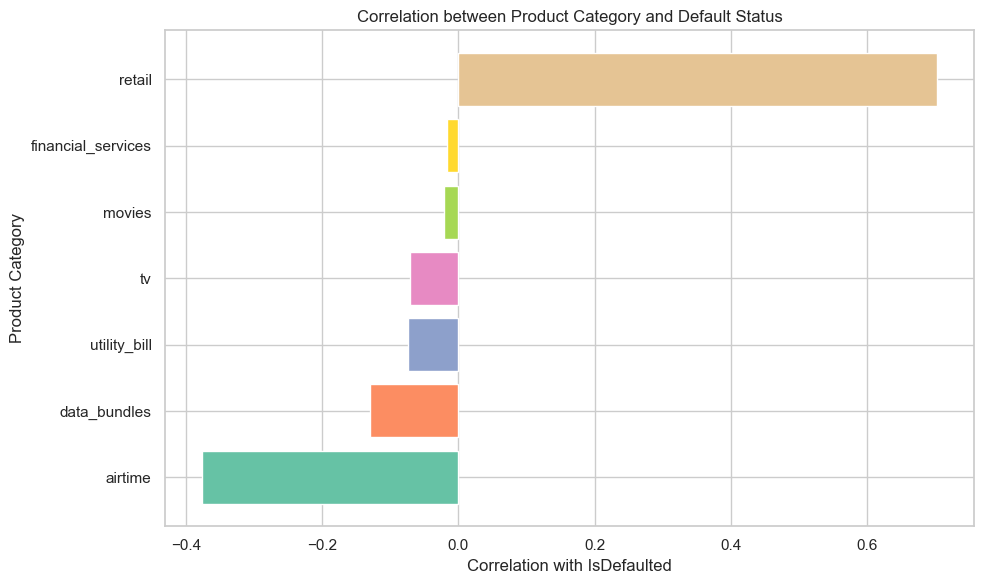

In [5]:
# Filter and clean relevant columns
df = train[['ProductCategory', 'IsDefaulted']].dropna()
df['IsDefaulted'] = pd.to_numeric(df['IsDefaulted'], errors='coerce').astype(int)

# One-hot encode ProductCategory
df_encoded = pd.get_dummies(df, columns=['ProductCategory'])

# Compute correlation
correlations = df_encoded.corr()['IsDefaulted'].drop('IsDefaulted').sort_values()

# Get unique color for each bar
category_names = correlations.index.str.replace('ProductCategory_', '')
num_categories = len(category_names)
colors = sns.color_palette('Set2', n_colors=num_categories)

# Plot bar chart with different colors
plt.figure(figsize=(10, 6))
bars = plt.barh(category_names, correlations.values, color=colors)
plt.title('Correlation between Product Category and Default Status')
plt.xlabel('Correlation with IsDefaulted')
plt.ylabel('Product Category')
plt.tight_layout()
plt.show()

In [6]:
plt.figure(figsize=(8, 5))
sns.violinplot(x='IsDefaulted', y='Value', data=df, palette='Set2', inner='quartile')
plt.xticks([0, 1], ['Not Defaulted (0)', 'Defaulted (1)'])
plt.title('Loan Amount Distribution by Default Status')
plt.xlabel('Default Status')
plt.ylabel('Loan Amount (Value)')
plt.tight_layout()
plt.show()

ValueError: Could not interpret value `Value` for `y`. An entry with this name does not appear in `data`.

<Figure size 800x500 with 0 Axes>

C:\Users\user\AppData\Local\Temp\ipykernel_6112\3146916671.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='IsDefaulted', y='Value', data=value_summary, palette=['mediumseagreen', 'salmon'])


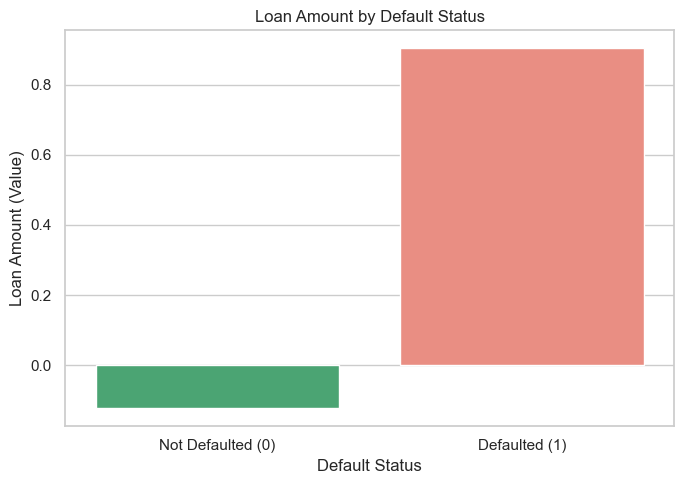

In [ ]:
df = train[['Value', 'IsDefaulted']].dropna()
df['IsDefaulted'] = pd.to_numeric(df['IsDefaulted'], errors='coerce').astype(int)

# Group by IsDefaulted and compute average loan amount
value_summary = df.groupby('IsDefaulted')['Value'].mean().reset_index()

# Plot the bar chart
plt.figure(figsize=(7, 5))
sns.barplot(x='IsDefaulted', y='Value', data=value_summary, palette=['mediumseagreen', 'salmon'])

# Customize axis and labels
plt.xticks([0, 1], ['Not Defaulted (0)', 'Defaulted (1)'])
plt.title('Loan Amount by Default Status')
plt.xlabel('Default Status')
plt.ylabel('Loan Amount (Value)')
plt.tight_layout()
plt.show()

In [12]:
num_cols = train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = train.select_dtypes(include=['object']).columns.tolist()

target = 'Good_Bad_flag'
if target in num_cols:
    num_cols.remove(target)

le = LabelEncoder()
for col in cat_cols:
    train[col] = le.fit_transform(train[col])

scaler = StandardScaler()
train[num_cols] = scaler.fit_transform(train[num_cols])
# Only use numeric columns for modeling
features = [col for col in train_set.columns if col not in ['IsDefaulted', 'Good_Bad_flag'] and train_set[col].dtype in [np.int64, np.float64]]

X_train = train_set[features]
y_train = train_set['IsDefaulted']
X_val = val_set[features]
y_val = val_set['IsDefaulted']

In [15]:
# Ensure IsDefaulted is integer and binary
train['IsDefaulted'] = pd.to_numeric(train['IsDefaulted'], errors='coerce').fillna(0).astype(int)

In [16]:
# Split train dataset: 70% training, 30% validation
train_set, val_set = train_test_split(train, test_size=0.3, random_state=42, stratify=train['IsDefaulted'] if 'IsDefaulted' in train.columns else None)

print("Training set shape:", train_set.shape)
print("Validation set shape:", val_set.shape)

Training set shape: (1035, 24)
Validation set shape: (444, 24)


In [17]:
from sklearn.linear_model import LogisticRegression

# Only use numeric columns for modeling
features = [col for col in train_set.columns if col not in ['IsDefaulted', 'Good_Bad_flag'] and train_set[col].dtype in [np.int64, np.float64]]

X_train = train_set[features]
y_train = train_set['IsDefaulted']
X_val = val_set[features]
y_val = val_set['IsDefaulted']

# Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_val)
print("Logistic Regression Results:")
print(classification_report(y_val, y_pred_logreg))
print("ROC-AUC:", roc_auc_score(y_val, logreg.predict_proba(X_val)[:, 1]))

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)
print("Random Forest Results:")
print(classification_report(y_val, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_val, rf.predict_proba(X_val)[:, 1]))

c:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       391
           2       0.72      0.74      0.73        53

    accuracy                           0.93       444
   macro avg       0.84      0.85      0.85       444
weighted avg       0.94      0.93      0.93       444

ROC-AUC: 0.9612507841528736
Random Forest Results:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       391
           2       1.00      0.92      0.96        53

    accuracy                           0.99       444
   macro avg       0.99      0.96      0.98       444
weighted avg       0.99      0.99      0.99       444

ROC-AUC: 0.9955122327848285
